# Optimizing the Text Generation Model

 We'll use the [Kaggle Song Lyrics Dataset](https://www.kaggle.com/mousehead/songlyrics) here.

## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

## Get the Dataset

As noted above, we'll utilize the [Song Lyrics dataset](https://www.kaggle.com/mousehead/songlyrics) on Kaggle again.

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2024-08-04 03:33:16--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 172.217.218.113, 172.217.218.138, 172.217.218.100, ...
Connecting to drive.google.com (drive.google.com)|172.217.218.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2024-08-04 03:33:16--  https://drive.usercontent.google.com/download?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.145.132, 2a00:1450:4013:c14::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.145.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72436445 (69M) [application/octet-stream]
Saving to: ‘/tmp/songdata.csv’

/tmp/songdata.csv   100%[===================>]  69.08M  93.5MB/s    in 0.7s    

2024-08-04 03:33:23 (9

### Preprocessing

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


<ipython-input-3-fbdddccf8583>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
<ipython-input-3-fbdddccf8583>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field] = dataset[field].str.lower()


### Create Sequences and Labels

In [5]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

### Train a (Better) Text Generation Model

With more data, we'll cut off after 100 epochs to avoid keeping you here all day. You'll also want to change your runtime type to GPU if you haven't already (you'll need to re-run the above cells if you change runtimes).

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam



model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # Use return_sequences for more complex patterns
model.add(Dropout(0.3))  # Add Dropout for regularization
model.add(Bidirectional(LSTM(128)))  # Additional LSTM layer
model.add(Dropout(0.3))  # Add Dropout for regularization
model.add(Dense(total_words, activation='softmax'))

# Use a learning rate schedule or different optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


history = model.fit(input_sequences, one_hot_labels, epochs=200, verbose=1)

Epoch 1/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.0459 - loss: 6.0951
Epoch 2/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.0839 - loss: 5.3954
Epoch 3/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.1113 - loss: 5.0503
Epoch 4/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.1338 - loss: 4.7985
Epoch 5/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.1532 - loss: 4.5541
Epoch 6/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.1754 - loss: 4.3588
Epoch 7/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.1950 - loss: 4.1886
Epoch 8/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.2163 - loss: 4.0272
Epoch 9/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.2380 - loss: 3.8768
Epoch 10/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.2593 - loss: 3.7153
Epoch 11/200
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.2719 - loss: 3.61

### View the Training Graph

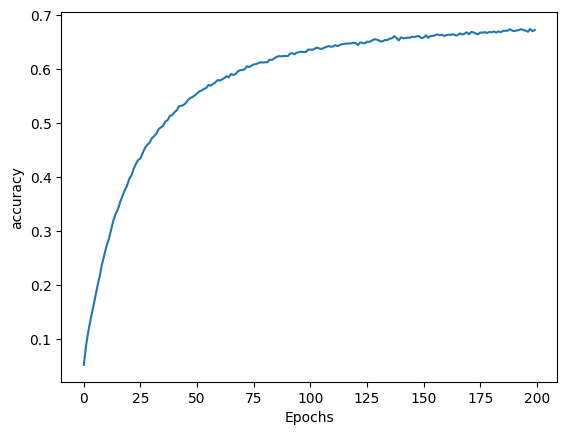

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate better lyrics!

This time around, we should be able to get a more interesting output with less repetition.

In [9]:
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

### Varying the Possible Outputs

In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output?

Switching from `model.predict_classes` to `model.predict_proba` will get us all of the class probabilities. We can combine this with `np.random.choice` to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [10]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100

token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))],
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
7


In [11]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100

for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━